<a href="https://colab.research.google.com/github/HARSHAZGREAT/Transfinitte23-/blob/main/Transfinitte_bg6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BG6: Skin Defects visual inspection by drone
Identify visual skin defects by drone by leveraging ML/AL latest**

In [6]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive
import json
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import layers
import random
from tensorflow import keras

In [7]:
!pip install keras-retinanet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp310-cp310-linux_x86_64.whl size=203716 sha256=7a15053bd4012139938e4a253262e0565b5e946dc36eb5b43215f9b49405c8e5
  Stored in directory: /root/.cache/pip/wheels/42/ee/d4/b54905a92241002b36db880e88b902ebcb015ce5ae311a16da
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20457 sha256=1cd7d6fd29c29be0da4a39e9885cb517af49c4be8ea3cdbe8fdc8f3ee500a6db
  Stored in directory: /root/.cache/pip/wheels/16/af/88/a668b279c5eadbe55dcaf6207f09059135166cefb09088bacc
Successfully built keras-retinanet keras-resnet


In [8]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [9]:

def resize_image(image, target_size):
    # Resize the image while maintaining the aspect ratio
    h, w, _ = image.shape
    if h > w:
        scale = target_size[0] / h
    else:
        scale = target_size[1] / w
    new_h = int(h * scale)
    new_w = int(w * scale)
    resized_image = cv2.resize(image, (new_w, new_h))

    # Add padding if necessary to reach the target size
    top_pad = (target_size[0] - new_h) // 2
    bottom_pad = target_size[0] - new_h - top_pad
    left_pad = (target_size[1] - new_w) // 2
    right_pad = target_size[1] - new_w - left_pad
    padded_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    return padded_image

def resize_bbox(bbox, original_size, target_size):
    x, y, width, height = bbox
    scale_x = target_size[1] / original_size[1]
    scale_y = target_size[0] / original_size[0]

    x *= scale_x
    y *= scale_y
    width *= scale_x
    height *= scale_y

    return [x, y, width, height]

In [10]:
category_dict = {'0': "'different-surface-defects'", '1': 'crack', '2': 'dent', '3': 'missing-head', '4': 'paint-off', '5': 'scratch'}

In [11]:
annotations_train_file = "/content/gdrive/MyDrive/ML datasets/aircraft-skin-defects-new-dataset.v4-classification-isolated-5-classes-grayscale-prep.coco/train/_annotations.coco.json"

with open(annotations_train_file, 'r') as file:
    annotations_train = json.load(file)

print(annotations_train)
print(annotations_train.keys())
print(annotations_train.values())

info = annotations_train['info']
licenses = annotations_train['licenses']
categories = annotations_train['categories']
images = annotations_train['images']
annotations = annotations_train['annotations']
data_trainset = []
path_add = "/content/gdrive/MyDrive/ML datasets/aircraft-skin-defects-new-dataset.v4-classification-isolated-5-classes-grayscale-prep.coco/train/"

print(len(categories), len(images), len(annotations))
print(categories)

target_size = (320, 320)

for j in range(0, 50):
  i = random.randint(0,len(images)-1)
  image_file_name = images[i]['file_name']
  image_id = images[i]['id']
  height = images[i]['height']
  width = images[i]['width']
  category_id =  annotations[i]['category_id']
  category_id =  str(category_id)
  category = category_dict[category_id]
  bbox =  annotations[i]['bbox']
  image_full_path = os.path.join(path_add, image_file_name)
  image_path = image_full_path

  image = cv2.imread(image_full_path)
  resized_image = resize_image(image, target_size)
  resized_bbox = resize_bbox(bbox, image.shape[:2], target_size)

  image_data = {'image_id': image_id, 'image_array': resized_image, 'image_path': image_path, 'category': category, 'bbox': resized_bbox, 'original height': height, 'original width': width }
  data_trainset.append(image_data)

{'info': {'year': '2023', 'version': '4', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-10-10T04:04:09+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'different-surface-defects', 'supercategory': 'none'}, {'id': 1, 'name': 'crack', 'supercategory': 'different-surface-defects'}, {'id': 2, 'name': 'dent', 'supercategory': 'different-surface-defects'}, {'id': 3, 'name': 'missing-head', 'supercategory': 'different-surface-defects'}, {'id': 4, 'name': 'paint-off', 'supercategory': 'different-surface-defects'}, {'id': 5, 'name': 'scratch', 'supercategory': 'different-surface-defects'}], 'images': [{'id': 0, 'license': 1, 'file_name': 'IMG_20230512_125235_jpg.rf.c8572b1bfeaa68b0846617f04abfd02e.jpg', 'height': 195, 'width': 238, 'date_captured': '2023-10-10T04:04:09+00:00'}, {'id': 1, 'license':

[0.9014084507042254, 0.4507042253521127, 319.0985915492958, 319.5492957746479]


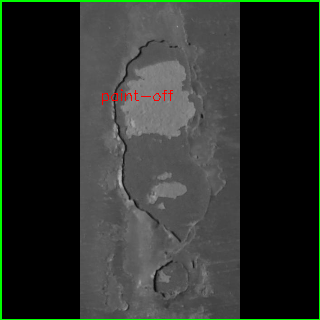

[0.7804878048780488, 0.7095343680709535, 319.219512195122, 319.29046563192907]


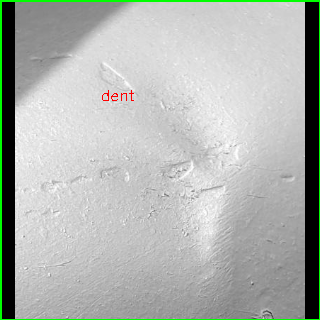

[0.7980049875311721, 0.0, 319.20199501246884, 320.0]


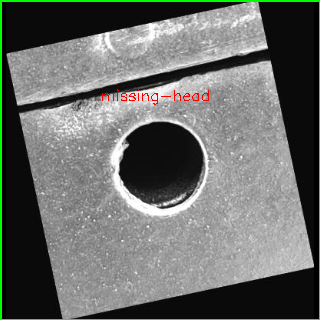

[0.0, 0.5893186003683242, 320.0, 319.4106813996317]


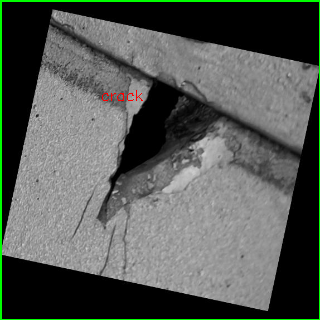

[0.0, 0.0, 320.0, 320.0]


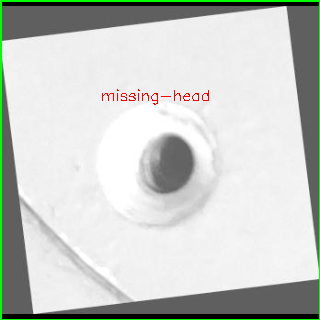

In [12]:
count = 0

for i in data_trainset:
    image = i.get("image_array")
    bbox = i.get("bbox")
    category = i.get("category")
    print(i.get("bbox"))
    color = (0, 255, 0)
    thickness = 2

    x, y, width, height = bbox
    x2, y2 = x + width, y + height
    cv2.rectangle(image, (int(x), int(y)), (int(x2), int(y2)), color, thickness)
    cv2.putText(image, category, (int(bbox[0] +100), int(bbox[1]) + 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2_imshow(image)
    count += 1
    if count == 5:
        break

In [13]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [14]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [15]:
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [16]:
!pip install pyyaml==5.3
!pip install /content/models/research/

!pip install tensorflow==2.8.0

  Using cached PyYAML-5.3.tar.gz (268 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Processing ./models/research
  Preparing metadata (setup.py) ... done
  Using cached avro-python3-1.10.2.tar.gz (38 kB)
  Preparing metadata (setup.py) ... done
  Using cached apache_beam-2.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 MB)
  Using cached lvis-0.5.3-py3-none-any.whl (14 kB)
  Using cached tf_models_official-2.8.0-py2.py3-none-any.whl (2.2 MB)
  Using cached tensorflow_io-0.34.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_

In [17]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

Traceback (most recent call last):
  File "/content/models/research/object_detection/builders/model_builder_tf2_test.py", line 24, in <module>
    from object_detection.builders import model_builder
ModuleNotFoundError: No module named 'object_detection'


In [18]:
import numpy as np
import cv2
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras.applications import MobileNetV2
from keras.models import load_model

pretrained_model = MobileNetV2(weights='imagenet', include_top=True)

pretrained_model.save('pretrained_mobilenetv2.h5')

model = models.load_model('path_to_your_pretrained_model.h5', backbone_name='mobilenet224')

labels_to_names = {0: "'different-surface-defects'", 1: 'crack', 2: 'dent', 3: 'missing-head', 4: 'paint-off', 5: 'scratch'}

image = read_image_bgr('path_to_your_image.jpg')
image = preprocess_image(image)
image, scale = resize_image(image)

boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

boxes /= scale

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.5:
        break

    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    caption = f"{labels_to_names[label]}: {score:.3f}"
    draw_caption(image, b, caption)

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

'\nimport numpy as np\nimport cv2\nfrom keras_retinanet import models\nfrom keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image\nfrom keras_retinanet.utils.visualization import draw_box, draw_caption\nfrom keras_retinanet.utils.colors import label_color\nfrom keras.applications import MobileNetV2\nfrom keras.models import load_model\n\n# Step 1: Import the pre-trained model\npretrained_model = MobileNetV2(weights=\'imagenet\', include_top=True)\n\n# Step 2: Save the model as a .h5 file\npretrained_model.save(\'pretrained_mobilenetv2.h5\')\n\n# Load the pre-trained model\nmodel = models.load_model(\'path_to_your_pretrained_model.h5\', backbone_name=\'mobilenet224\')\n\n# Load class labels\nlabels_to_names = {0: "\'different-surface-defects\'", 1: \'crack\', 2: \'dent\', 3: \'missing-head\', 4: \'paint-off\', 5: \'scratch\'}\n\n# Load and preprocess an image\nimage = read_image_bgr(\'path_to_your_image.jpg\')\nimage = preprocess_image(image)\nimage, scale = 